In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt 
import os
import pathlib
import tensorflow_addons as tfa
from tensorflow.python.client import device_lib

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  4


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')

In [4]:
tf.config.set_visible_devices(
    physical_devices[1], 'GPU'
)

# Data Loading 

The size of the receptive field in our network is 224×224 taking RGB color channels with mean subtraction.
* Still, one prescription that was verified to work very well after the competition includes sampling of various sized patches of the image whose size is distributed evenly between 8% and 100% of the image area and whose aspect ratio is chosen randomly between 3/4 and 4/3.

In [5]:
path_train = 'CINIC10/train/'
path_valid = 'CINIC10/valid/'
path_test = 'CINIC10/test/'
data_dir_train = pathlib.Path(path_train)
data_dir_val = pathlib.Path(path_valid)
data_dir_test = pathlib.Path(path_test)

In [6]:
list_ds_train = tf.data.Dataset.list_files(str(data_dir_train/'*/*'))
list_ds_val = tf.data.Dataset.list_files(str(data_dir_val/'*/*'))
list_ds_test = tf.data.Dataset.list_files(str(data_dir_test/'*/*'))

In [7]:
CLASS_NAMES = np.array([item.name for item in data_dir_train.glob('*')])

In [8]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == CLASS_NAMES

In [9]:
def decode_img(img,dsize):
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, [dsize[0], dsize[1]])

In [10]:
def process_path(file_path):
    size = (224,224)
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img,size )
    return img, label

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [12]:
labeled_ds_train = list_ds_train.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_ds_valid = list_ds_val.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_ds_test = list_ds_test.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
def normalize(x,y):
    x = tf.image.per_image_standardization(x)
    return x,y

In [14]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000, batch_size = 128):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    ds = ds.map(normalize)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [15]:
train_ds = prepare_for_training(labeled_ds_train, batch_size=64)
val_ds = prepare_for_training(labeled_ds_valid, batch_size=64)
test_ds = prepare_for_training(labeled_ds_test, batch_size=64)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


# GoogLeNet Details

* $1\times1$ convolutions have dual purpose: most critically, they are used mainly as dimension reduction modules to remove computational bottlenecks, that would otherwise limit the size of our networks. This allows for not just increasing the depth, but also the width of the networks without significant performance penalty.
* stochastic gradient descent with 0.9 momentum
* fixed learning rate schedule (decreasing the learning rate by 4% every 8 epochs)

# Model Definition

In [16]:
def initial_block(inputs):
    kernel_init = tf.keras.initializers.GlorotNormal()
    x = tf.keras.layers.Conv2D(64, kernel_size=7, kernel_initializer = kernel_init, strides=2, padding = 'same', activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    x = tf.keras.layers.Conv2D(192, kernel_size=3, kernel_initializer = kernel_init, padding = 'same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x

In [17]:
def inception_block3a(x, 
                      n_channels_1_1,
                      n_channels_3_3_red, 
                      n_channels_3_3, 
                      n_channels_5_5_red, 
                      n_channels_5_5,
                      n_channels_pool_proj):
    kernel_init = tf.keras.initializers.GlorotNormal()
    res_conv1 = tf.keras.layers.Conv2D(n_channels_1_1, kernel_size=1, kernel_initializer = kernel_init, padding='same', activation='relu')(x)
    res_conv3_reduce = tf.keras.layers.Conv2D(n_channels_3_3_red, kernel_size=1,  kernel_initializer = kernel_init, padding='same', activation='relu')(x)
    res_conv3 = tf.keras.layers.Conv2D(n_channels_3_3, kernel_size=3,  kernel_initializer = kernel_init, padding='same', activation='relu')(res_conv3_reduce)
    res_conv5_reduce = tf.keras.layers.Conv2D(n_channels_5_5_red, kernel_size=1,  kernel_initializer = kernel_init, padding='same', activation='relu')(x)
    res_conv5 = tf.keras.layers.Conv2D(n_channels_5_5, kernel_size=5,  kernel_initializer = kernel_init, padding='same', activation='relu')(res_conv5_reduce)
    res_max_pool = tf.keras.layers.MaxPool2D(pool_size=3, padding='same', strides=1)(x)
    res_max_pool_proj = tf.keras.layers.Conv2D(n_channels_pool_proj,kernel_size=1,  kernel_initializer = kernel_init, padding='same', activation='relu')(res_max_pool)
    result_bock = tf.keras.layers.concatenate([res_conv1, res_conv3, res_conv5, res_max_pool_proj], axis=3)
    return result_bock

In [18]:
def final_block(x, n_classes):
    x = tf.keras.layers.AveragePooling2D(pool_size=7, strides=1)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(1000, activation='relu')(x)
    x = tf.keras.layers.Dense(n_classes,activation='softmax')(x)
    return x
    

In [28]:
def model(n_classes):
    inputs = tf.keras.layers.Input(shape=(224,224,3))
    x = initial_block(inputs)
    x = inception_block3a(x, 64, 96, 128, 16, 32, 32)
    x = inception_block3a(x, 128, 128, 192, 32, 96, 64)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    x = inception_block3a(x, 192, 96, 208, 16, 48, 64)
    x = inception_block3a(x, 160, 112, 224, 24, 64, 64)
    x = inception_block3a(x, 128, 128, 256, 24, 64, 64)
    x = inception_block3a(x, 112, 144, 288, 32, 64, 64)
    x = inception_block3a(x, 256, 160, 320, 32, 128, 128)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    x = inception_block3a(x, 256, 160, 320, 32, 128, 128)
    x = inception_block3a(x, 384, 192, 384, 48, 128, 128)
    x = final_block(x,10)
    model = tf.keras.Model(inputs, x)
    return model

In [29]:
model = model(10)

In [30]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 112, 112, 64) 256         conv2d_56[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 56, 56, 64)   0           batch_normalization_3[0][0]      
____________________________________________________________________________________________

# Training

In [31]:
model.compile(optimizer=tfa.optimizers.SGDW(momentum=0.9, weight_decay=0.0001, learning_rate=0.01),
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [32]:
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.04
    epochs_drop = 8.0
    lrate = initial_lrate * tf.math.pow(drop,tf.math.floor((1+epoch)/epochs_drop))
    return lrate

In [33]:
lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

In [34]:
history = model.fit(train_ds,
                   epochs=74,
                   #callbacks = [lrate],
                   steps_per_epoch = 100,
                   verbose = 1,
                   validation_data = val_ds,
                   validation_steps = 100)

Train for 100 steps, validate for 100 steps
Epoch 1/74
100/100 [==============================] - 17s 167ms/step - loss: 2.1658 - accuracy: 0.1659 - val_loss: 2.1589 - val_accuracy: 0.2295
Epoch 2/74
100/100 [==============================] - 14s 136ms/step - loss: 2.0047 - accuracy: 0.2098 - val_loss: 2.0183 - val_accuracy: 0.2209
Epoch 3/74
100/100 [==============================] - 14s 137ms/step - loss: 1.9205 - accuracy: 0.2447 - val_loss: 2.0064 - val_accuracy: 0.2336
Epoch 4/74
100/100 [==============================] - 14s 136ms/step - loss: 1.8748 - accuracy: 0.2655 - val_loss: 1.8939 - val_accuracy: 0.2539
Epoch 5/74
100/100 [==============================] - 14s 137ms/step - loss: 1.8160 - accuracy: 0.2733 - val_loss: 1.8938 - val_accuracy: 0.2805
Epoch 6/74
100/100 [==============================] - 14s 137ms/step - loss: 1.7988 - accuracy: 0.2983 - val_loss: 1.7335 - val_accuracy: 0.3116
Epoch 7/74
100/100 [==============================] - 14s 137ms/step - loss: 1.7633 - 

# Evaluation

In [35]:
loss_test, accuracy_test = model.evaluate(test_ds,
                                        verbose = 1,
                                        steps = 5)

5/5 [==============================] - 4s 885ms/step - loss: 1.2291 - accuracy: 0.5625


In [36]:
loss_test, accuracy_test

(1.2291229486465454, 0.5625)

# Training results visualization

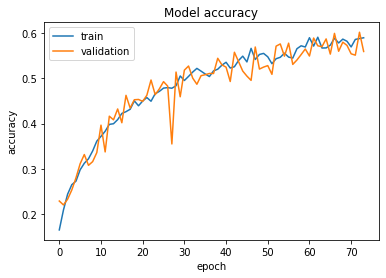

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

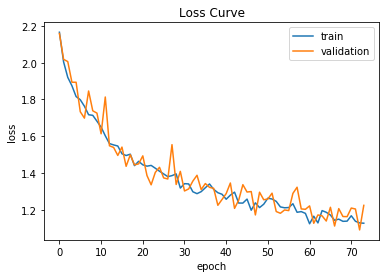

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()